In [71]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

from pydrake.all import (
    ConstantVectorSource,
    DiagramBuilder,
    InverseKinematics,
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    MultibodyPlant,
    Parser,
    PiecewisePolynomial,
    PiecewiseQuaternionSlerp,
    RigidTransform,
    RollPitchYaw,
    RotationMatrix,
    Simulator,
    Solve,
    StartMeshcat,
    TrajectorySource,
)
from pydrake.multibody import inverse_kinematics
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.trajectories import PiecewisePolynomial

from manipulation import FindResource
from manipulation.meshcat_utils import AddMeshcatTriad, MeshcatPoseSliders
from manipulation.scenarios import AddIiwa, AddWsg, AddMultibodyTriad, MakeManipulationStation, AddRgbdSensors
from manipulation.station import AddPointClouds, load_scenario, MakeHardwareStation
from manipulation.utils import running_as_notebook, ConfigureParser

In [64]:
# Start the visualizer. The cell will output an HTTP link after the execution.
# Click the link and a MeshCat tab should appear in your browser.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7006


In [75]:
meshcat.Delete()

In [76]:
def CreateIiwaControllerPlant():
    """creates plant that includes only the robot and gripper, used for controllers."""
    robot_sdf_path = "package://drake/manipulation/models/iiwa_description/iiwa7/iiwa7_no_collision.sdf"
    gripper_sdf_path = "package://drake/manipulation/models/wsg_50_description/sdf/schunk_wsg_50_no_tip.sdf"
    sim_timestep = 1e-3
    plant_robot = MultibodyPlant(sim_timestep)
    parser = Parser(plant=plant_robot)
    parser.AddModelsFromUrl(robot_sdf_path)
    parser.AddModelsFromUrl(gripper_sdf_path)
    plant_robot.WeldFrames(
        frame_on_parent_F=plant_robot.world_frame(),
        frame_on_child_M=plant_robot.GetFrameByName("iiwa_link_0"),
    )
    plant_robot.WeldFrames(
        frame_on_parent_F=plant_robot.GetFrameByName("iiwa_link_7"),
        frame_on_child_M=plant_robot.GetFrameByName("body"),
        X_FM=RigidTransform(
            RollPitchYaw(np.pi / 2, 0, np.pi / 2), np.array([0, 0, 0.114])
        ),
    )
    plant_robot.mutable_gravity_field().set_gravity_vector([0, 0, 0])
    plant_robot.Finalize()

    link_frame_indices = []
    for i in range(8):
        link_frame_indices.append(
            plant_robot.GetFrameByName("iiwa_link_" + str(i)).index()
        )

    return plant_robot, link_frame_indices

def BuildAndSimulateTrajectory(q_traj, g_traj, duration=0.01):
    """Simulate trajectory for manipulation station.
    @param q_traj: Trajectory class used to initialize TrajectorySource for joints.
    @param g_traj: Trajectory class used to initialize TrajectorySource for gripper.
    """
    builder = DiagramBuilder()
    scenario = load_scenario(
        filename = "/workspaces/manip-final-project/withcamera.scenarios.yaml",
        scenario_name = "Tennis"
    )
    station = builder.AddSystem(MakeHardwareStation(scenario, meshcat=meshcat))
    plant = station.GetSubsystemByName("plant")
    scene_graph = station.GetSubsystemByName("scene_graph")
    AddMultibodyTriad(plant.GetFrameByName("body"), scene_graph)

    q_traj_system = builder.AddSystem(TrajectorySource(q_traj))
    g_traj_system = builder.AddSystem(TrajectorySource(g_traj))

    visualizer = MeshcatVisualizer.AddToBuilder(
        builder,
        station.GetOutputPort("query_object"),
        meshcat,
        MeshcatVisualizerParams(delete_on_initialization_event=False),
    )

    builder.Connect(
        q_traj_system.get_output_port(), station.GetInputPort("iiwa.position")
    )
    builder.Connect(
        g_traj_system.get_output_port(), station.GetInputPort("wsg.position")
    )

    diagram = builder.Build()

    simulator = Simulator(diagram)
    visualizer.StartRecording(False)
    simulator.AdvanceTo(duration)
    visualizer.PublishRecording()

    return simulator, plant

def setup_manipulation_station():
    builder = DiagramBuilder()
    scenario = load_scenario(
        filename = "/workspaces/manip-final-project/withcamera.scenarios.yaml",
        scenario_name = "Tennis"
    )
    station = builder.AddSystem(MakeHardwareStation(scenario, meshcat=meshcat))
    plant = station.GetSubsystemByName("plant")
    scene_graph = station.GetSubsystemByName("scene_graph")
    AddMultibodyTriad(plant.GetFrameByName("body"), scene_graph)

    MeshcatVisualizer.AddToBuilder(
        builder,
        station.GetOutputPort("query_object"),
        meshcat,
        MeshcatVisualizerParams(delete_on_initialization_event=False),
    )

    wsg_position = builder.AddSystem(ConstantVectorSource([0.1]))
    builder.Connect(
        wsg_position.get_output_port(), station.GetInputPort("wsg.position")
    )

    diagram = builder.Build()

    context = plant.CreateDefaultContext()
    gripper = plant.GetBodyByName("body")

    initial_pose = plant.EvalBodyPoseInWorld(context, gripper)

    simulator = Simulator(diagram)
    simulator.set_target_realtime_rate(1.0)
    simulator.AdvanceTo(0.01)

    return initial_pose

initial_pose = setup_manipulation_station()

In [ ]:
pickup_rpy = RollPitchYaw([-np.pi/2, 0, np.pi/2])
pickup_rotation = RotationMatrix(pickup_rpy)
pickup_position = np.array([0.5, 0, 0.31])
pickup_pose = RigidTransform(pickup_rotation, pickup_position)

up_position = np.array([0.5, 0, 1])
up_pose = RigidTransform(pickup_rotation, up_position)

turn_rpy = RollPitchYaw([-np.pi/2, 0, 0])
turn_rotation = RotationMatrix(turn_rpy)
turn_position = np.array([0, 0.5, 0.5])
turn_pose = RigidTransform(turn_rotation, turn_position)

load_rpy = RollPitchYaw([-2, 0, 0])
load_rotation = RotationMatrix(load_rpy)
load_position = np.array([0, 0.5, 0.5])
load_pose = RigidTransform(load_rotation, load_position)

throw_rpy = RollPitchYaw([-1, 0, 0])
throw_rotation = RotationMatrix(throw_rpy)
throw_position = np.array([0, 0.5, 0.5])
throw_pose = RigidTransform(throw_rotation, throw_position)

## Interpolate Pose for entry.
def make_gripper_orientation_trajectory(prev_pose, pose):
    traj = PiecewiseQuaternionSlerp()
    traj.Append(0.0, prev_pose.rotation())
    traj.Append(5.0, pose.rotation())
    return traj

def make_gripper_position_trajectory(prev_pose, pose):
    traj = PiecewisePolynomial.FirstOrderHold(
        [0.0, 5.0],
        np.vstack(
            [
                [prev_pose.translation()],
                [pose.translation()],
            ]
        ).T,
    )
    return traj

entry_traj_rotation = make_gripper_orientation_trajectory(initial_pose, pickup_pose)
entry_traj_translation = make_gripper_position_trajectory(initial_pose, pickup_pose)
up_traj_rotation = make_gripper_orientation_trajectory(pickup_pose, up_pose)
up_traj_translation = make_gripper_position_trajectory(pickup_pose, up_pose)

def InterpolatePosePickup(t):
    if t < 5: 
        return RigidTransform(
            RotationMatrix(entry_traj_rotation.orientation(t)),
            entry_traj_translation.value(t),
        )
    elif t >= 5 and t < 6:
        return RigidTransform(
            RotationMatrix(entry_traj_rotation.orientation(5.0)),
            entry_traj_translation.value(5.0),
        )
    else: 
        return RigidTransform(
            RotationMatrix(up_traj_rotation.orientation((t - 6)/5)),
            up_traj_translation.value((t - 6)/5),
        )

t_lst = np.linspace(0, 11, 10)
pose_lst = []
for t in t_lst:
    AddMeshcatTriad(meshcat, path=str(t), X_PT=InterpolatePosePickup(t), opacity=0.2)
    pose_lst.append(InterpolatePosePickup(t))

# Create gripper trajectory.
gripper_t_lst = np.array([0.0, 5.0, 6.0, 11.0])
gripper_knots = np.array([0.11, 0.11, 0.05, 0.0]).reshape(1, 4)
g_traj = PiecewisePolynomial.FirstOrderHold(gripper_t_lst, gripper_knots)

def create_q_knots(pose_lst):
    """Convert end-effector pose list to joint position list using series of
    InverseKinematics problems. Note that q is 9-dimensional because the last 2 dimensions
    contain gripper joints, but these should not matter to the constraints.
    @param: pose_lst (python list): post_lst[i] contains keyframe X_WG at index i.
    @return: q_knots (python_list): q_knots[i] contains IK solution that will give f(q_knots[i]) \approx pose_lst[i].
    """
    q_knots = []
    plant, _ = CreateIiwaControllerPlant()
    world_frame = plant.world_frame()
    gripper_frame = plant.GetFrameByName("body")
    q_nominal = np.array(
        [0.0, 0.6, 0.0, -1.75, 0.0, 1.0, 0.0, 0.0, 0.0]
    )  # nominal joint angles for joint-centering.

    def AddOrientationConstraint(ik, R_WG, bounds):
        """Add orientation constraint to the ik problem. Implements an inequality
        constraint where the axis-angle difference between f_R(q) and R_WG must be
        within bounds. Can be translated to:
        ik.prog().AddBoundingBoxConstraint(angle_diff(f_R(q), R_WG), -bounds, bounds)
        """
        ik.AddOrientationConstraint(
            frameAbar=world_frame,
            R_AbarA=R_WG,
            frameBbar=gripper_frame,
            R_BbarB=RotationMatrix(),
            theta_bound=bounds,
        )

    def AddPositionConstraint(ik, p_WG_lower, p_WG_upper):
        """Add position constraint to the ik problem. Implements an inequality
        constraint where f_p(q) must lie between p_WG_lower and p_WG_upper. Can be
        translated to
        ik.prog().AddBoundingBoxConstraint(f_p(q), p_WG_lower, p_WG_upper)
        """
        ik.AddPositionConstraint(
            frameA=world_frame,
            frameB=gripper_frame,
            p_BQ=np.zeros(3),
            p_AQ_lower=p_WG_lower,
            p_AQ_upper=p_WG_upper,
        )

    for i in range(len(pose_lst)):
        ik = inverse_kinematics.InverseKinematics(plant)
        q_variables = ik.q()  # Get variables for MathematicalProgram
        prog = ik.prog()  # Get MathematicalProgram

        #### Modify here ###############################

        if i == 0:
            prog.SetInitialGuess(q_variables, q_nominal)
        else:
            prog.SetInitialGuess(q_variables, q_knots[i - 1])

        x = q_variables - q_nominal
        prog.AddCost(x.dot(x))
        X_WG = pose_lst[i]
        p_WG = X_WG.translation()
        z_epsilon = 0.01
        theta_epsilon = 0.05
        p_WG_lower = np.array([p_WG[0], p_WG[1], p_WG[2] - z_epsilon])
        p_WG_upper = np.array([p_WG[0], p_WG[1], p_WG[2] + z_epsilon])
        R_WG = X_WG.rotation()
        AddPositionConstraint(ik, p_WG_lower, p_WG_upper)
        AddOrientationConstraint(ik, R_WG, theta_epsilon)

        ################################################

        result = Solve(prog)

        assert result.is_success()

        q_knots.append(result.GetSolution(q_variables))

    return q_knots

In [56]:
q_knots = np.array(create_q_knots(pose_lst))
q_traj = PiecewisePolynomial.CubicShapePreserving(t_lst, q_knots[:, 0:7].T)
simulator, station_plant = BuildAndSimulateTrajectory(q_traj, g_traj, 11.0)

In [65]:
def run_simulation():
    builder = DiagramBuilder()
    time_step = 0.001
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step)
    Parser(plant).AddModels("model.sdf")
    iiwa = AddIiwa(plant, "with_box_collision")
    wsg = AddWsg(plant, iiwa, welded=True)
    plant.Finalize()

    visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    # logger = LogVectorOutput(plant.get_state_output_port(), builder)

    diagram = builder.Build()
    simulator = Simulator(diagram)

    # meshcat.StartRecording()

    context = simulator.get_mutable_context()
    plant_context = plant.GetMyMutableContextFromRoot(context)
    # plant.SetPositions(plant_context, [1])
    q0 = plant.GetPositions(plant_context)
    gripper_frame = plant.GetFrameByName("body", wsg)

    def my_callback(context, pose):
        ik = InverseKinematics(plant, plant_context)
        ik.AddPositionConstraint(
            gripper_frame,
            [0, 0, 0],
            plant.world_frame(),
            pose.translation(),
            pose.translation(),
        )
        ik.AddOrientationConstraint(
            gripper_frame,
            RotationMatrix(),
            plant.world_frame(),
            pose.rotation(),
            0.0,
        )
        prog = ik.get_mutable_prog()
        q = ik.q()
        prog.AddQuadraticErrorCost(np.identity(len(q)), q0, q)
        prog.SetInitialGuess(q, q0)
        result = Solve(ik.prog())
        if result.is_success():
            print("IK success")
        else:
            print("IK failure")
        clear_output(wait=True)

    meshcat.DeleteAddedControls()
    sliders = MeshcatPoseSliders(meshcat)
    sliders.SetPose(
        plant.EvalBodyPoseInWorld(
            plant_context, plant.GetBodyByName("body", wsg)
        )
    )
    sliders.Run(visualizer, context, my_callback)

    # simulator.AdvanceTo(3 if running_as_notebook else 0.1)
    # meshcat.PublishRecording()

# These are the default values that MultibodyPlant picked (on Nov 16, 2022) for
# this system.
run_simulation()

KeyboardInterrupt: 

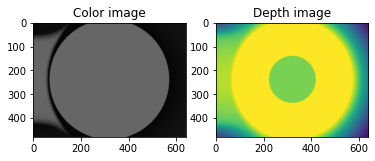

In [73]:
scenario_data = """
directives:
- add_model:
    name: iiwa
    file: package://drake/manipulation/models/iiwa_description/iiwa7/iiwa7_no_collision.sdf
    default_joint_positions:
        iiwa_joint_1: [0]
        iiwa_joint_2: [1]
        iiwa_joint_3: [0]
        iiwa_joint_4: [-0.5]
        iiwa_joint_5: [0]
        iiwa_joint_6: [0.5]
        iiwa_joint_7: [0]
- add_weld:
    parent: world
    child: iiwa::iiwa_link_0
- add_model:
    name: wsg
    file: package://drake/manipulation/models/wsg_50_description/sdf/schunk_wsg_50_no_tip.sdf
- add_weld:
    parent: iiwa::iiwa_link_7
    child: wsg::body
    X_PC:
        translation: [0, 0, 0.082] # 0.114
        rotation: !Rpy { deg: [90, 0, 90]}
- add_model:
    name: bottle
    file: file:///workspaces/manip-final-project/model.sdf

- add_model:
    name: camera
    file: package://manipulation/camera_box.sdf


cameras:
    main_camera:
        name: camera0
        depth: True
        X_PB:
            base_frame: camera::base
"""


def DepthCameraDemoSystem():
    builder = DiagramBuilder()

    scenario = load_scenario(data=scenario_data)
    station = builder.AddSystem(MakeHardwareStation(scenario, meshcat))

    # Export the camera outputs
    builder.ExportOutput(
        station.GetOutputPort("camera0.rgb_image"), "rgb_image"
    )
    builder.ExportOutput(
        station.GetOutputPort("camera0.depth_image"), "depth_image"
    )

    to_point_cloud = AddPointClouds(
        scenario=scenario, station=station, builder=builder, meshcat=meshcat
    )

    # Add a box for the camera in the environment.
    plant = station.GetSubsystemByName("plant")
    camera_instance = plant.GetModelInstanceByName("camera")
    scene_graph = station.GetSubsystemByName("scene_graph")
    AddMultibodyTriad(
        plant.GetFrameByName("base", camera_instance),
        scene_graph,
        length=0.1,
        radius=0.005,
    )

    # Export the point cloud output.
    builder.ExportOutput(
        to_point_cloud["camera0"].point_cloud_output_port(), "point_cloud"
    )

    diagram = builder.Build()
    diagram.set_name("depth_camera_demo_system")
    return diagram


def plot_camera_images():
    system = DepthCameraDemoSystem()

    # Evaluate the camera output ports to get the images.
    context = system.CreateDefaultContext()
    system.ForcedPublish(context)
    color_image = system.GetOutputPort("rgb_image").Eval(context)
    depth_image = system.GetOutputPort("depth_image").Eval(context)

    # Plot the two images.
    plt.subplot(121)
    plt.imshow(color_image.data)
    plt.title("Color image")
    plt.subplot(122)
    plt.imshow(np.squeeze(depth_image.data))
    plt.title("Depth image")
    # mpld3.display()
    plt.show()


plot_camera_images()